# Imports

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Constants

In [2]:
dataset_paths = [
    '/kaggle/input/zocdoc/new_jersey.csv',
    '/kaggle/input/zocdoc/new_jersey_cardiologist.csv',
    '/kaggle/input/zocdoc/new_jersey_chiropractor.csv',
    '/kaggle/input/zocdoc/new_jersey_dentist.csv',
    '/kaggle/input/zocdoc/new_jersey_dermatologist.csv',
    '/kaggle/input/zocdoc/new_jersey_dietitian.csv',
    '/kaggle/input/zocdoc/new_jersey_ent.csv',
    '/kaggle/input/zocdoc/new_jersey_gastroenterologist.csv',
    '/kaggle/input/zocdoc/new_jersey_neurosurgeon.csv',
    '/kaggle/input/zocdoc/new_jersey_ob-gyn.csv',
    '/kaggle/input/zocdoc/new_jersey_oncologist.csv',
    '/kaggle/input/zocdoc/new_jersey_optometrist.csv',
    '/kaggle/input/zocdoc/new_jersey_orthopedic.csv',
    '/kaggle/input/zocdoc/new_jersey_orthopedic_surgeon.csv',
    '/kaggle/input/zocdoc/new_jersey_pain_management.csv',
    '/kaggle/input/zocdoc/new_jersey_physical_therapist.csv',
    '/kaggle/input/zocdoc/new_jersey_podiatrist.csv',
    '/kaggle/input/zocdoc/new_jersey_primary_care_physician.csv',
    '/kaggle/input/zocdoc/new_jersey_psychiatrist.csv',
    '/kaggle/input/zocdoc/new_jersey_rheumatologist.csv',
    '/kaggle/input/zocdoc/new_jersey_sports_medicine_specialist.csv',
    '/kaggle/input/zocdoc/new_jersey_surgeon.csv'
]

# Utils

In [3]:
def get_data_file_paths():
    file_paths = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            file_paths.append(path)
    return sorted(file_paths)


def clean_dataset(path, speciality, keywords=''):
    # 1. Read dataset
    df = pd.read_csv(path)

    # 2. Drop duplicates
    df = df.drop_duplicates()

    # 3. Extract Drs
    df_drs = df[df['name'].str.lower().str.contains('dr')]
    df_drs = df_drs[df_drs['job_title'].str.lower().str.contains(f'internist|{keywords}')]
    df_drs = df_drs.assign(is_dr=1, is_nurse=0, is_assistant=0)

    # 4. Extract Non. Drs and assign nurse and assistants status to them
    df_no_drs = df[~df['name'].str.lower().str.contains('dr')]
    df_no_drs = df_no_drs.assign(is_dr=0, is_nurse=0, is_assistant=0)
    df_no_drs.loc[df_no_drs['job_title'].str.lower().str.contains('nurse'), 'is_nurse'] = 1
    df_no_drs.loc[df_no_drs['job_title'].str.lower().str.contains('assistant'), 'is_assistant'] = 1
    df_no_drs = df_no_drs[~((df_no_drs['is_nurse'] == 0) & (df_no_drs['is_assistant'] == 0))]
    print(f"Count non-assigned status rows: {len(df_no_drs[(df_no_drs['is_nurse']==0) & (df_no_drs['is_assistant']==0)])}")

    # 5. Combined both the dr and non-drs rows
    df_combined = pd.concat([df_drs, df_no_drs], ignore_index=True)
    
    # 6. Set 'job_title' to speciality name
    print(f"\n[Before] Job title unique values: {df_combined['job_title'].value_counts()}")
    df_combined['job_title'] = speciality
    
    # 7. Merge 'location_name' and 'street_address'
    df_combined['street_address'] = df_combined['location_name'].fillna('') + ' ' + df_combined['street_address'].fillna('')
    df_combined['street_address'] = df_combined['street_address'].str.strip()
    df_combined = df_combined.drop(columns=['location_name']) # Remove dedundant column

    # 8. Impute 'region' and 'postal_code' with their mode
    mode_region_series = df_combined['region'].mode()
    mode_postal_code_series = df_combined['postal_code'].mode()
    mode_region = 'NJ'
    mode_postal_code = 0
    
    if not mode_region_series.empty:
        mode_region = mode_region_series[0]
    if not mode_postal_code_series.empty:
        mode_postal_code = mode_postal_code_series[0]
    
    df_combined['region'] = df_combined['region'].fillna(mode_region)
    df_combined['postal_code'] = df_combined['postal_code'].fillna(mode_postal_code)
    
    # 9. Change column with object types to case
    df_combined['name'] = df_combined['name'].str.lower()
    df_combined['job_title'] = df_combined['job_title'].str.lower()
    df_combined['street_address'] = df_combined['street_address'].str.lower()
    df_combined['address_locality'] = df_combined['address_locality'].str.lower()
    df_combined['region'] = df_combined['region'].str.upper()
    
    # 10. Change 'postal_code' column type
    df_combined['postal_code'] = df_combined['postal_code'].astype(int)
    
    print(f"\n[After] Job title unique values: {df_combined['job_title'].value_counts()}")
    
    return df_combined


def check_plots(dataset):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Distribution of Job Titles
    sns.countplot(y='job_title', data=dataset, order=dataset['job_title'].value_counts().index, ax=axes[0])
    axes[0].set_title('Distribution of Job Titles')
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel('Job Title')

    # Plot 2: Distribution of Region
    sns.countplot(y='region', data=dataset, order=dataset['region'].value_counts().index, ax=axes[1])
    axes[1].set_title('Distribution of Region')
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('Region')

    # Plot 3: Distribution of Boolean Columns
    boolean_columns = ['is_dr', 'is_nurse', 'is_assistant']
    boolean_counts = dataset[boolean_columns].sum()
    sns.barplot(x=boolean_counts.index, y=boolean_counts.values, ax=axes[2])
    axes[2].set_title('Distribution of Boolean Columns')
    axes[2].set_xlabel('Role')
    axes[2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

# Code

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Cardiologist                        130
Nurse Practitioner (Cardiology)       9
Physician Assistant (Cardiology)      7
Family Nurse Practitioner             4
Nurse Practitioner                    1
Adult Nurse Practitioner              1
Physician Assistant                   1
Name: count, dtype: int64

[After] Job title unique values: job_title
cardiologist    153
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              153 non-null    object 
 1   job_title         153 non-null    object 
 2   rating            150 non-null    float64
 3   street_address    153 non-null    object 
 4   address_locality  151 non-null    object 
 5   region            153 non-null    object 
 6   postal_code       153 non-null    int64

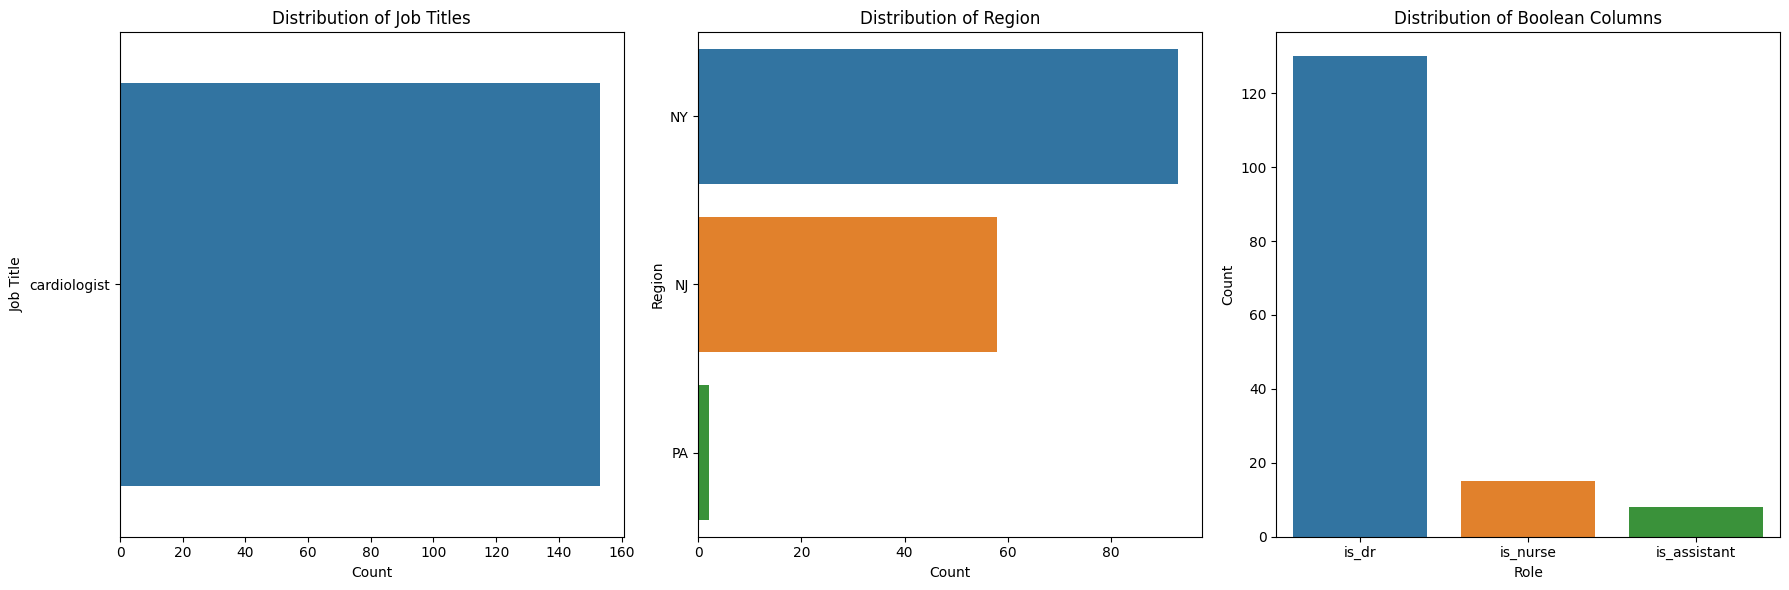

In [4]:
df_cardiologist = clean_dataset(dataset_paths[1], 'cardiologist', keywords='cardio')
df_cardiologist.info()
check_plots(df_cardiologist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Chiropractor    150
Internist         7
Name: count, dtype: int64

[After] Job title unique values: job_title
chiropractor    157
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              157 non-null    object 
 1   job_title         157 non-null    object 
 2   rating            148 non-null    float64
 3   street_address    157 non-null    object 
 4   address_locality  155 non-null    object 
 5   region            157 non-null    object 
 6   postal_code       157 non-null    int64  
 7   is_dr             157 non-null    int64  
 8   is_nurse          157 non-null    int64  
 9   is_assistant      157 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 12.4+ KB


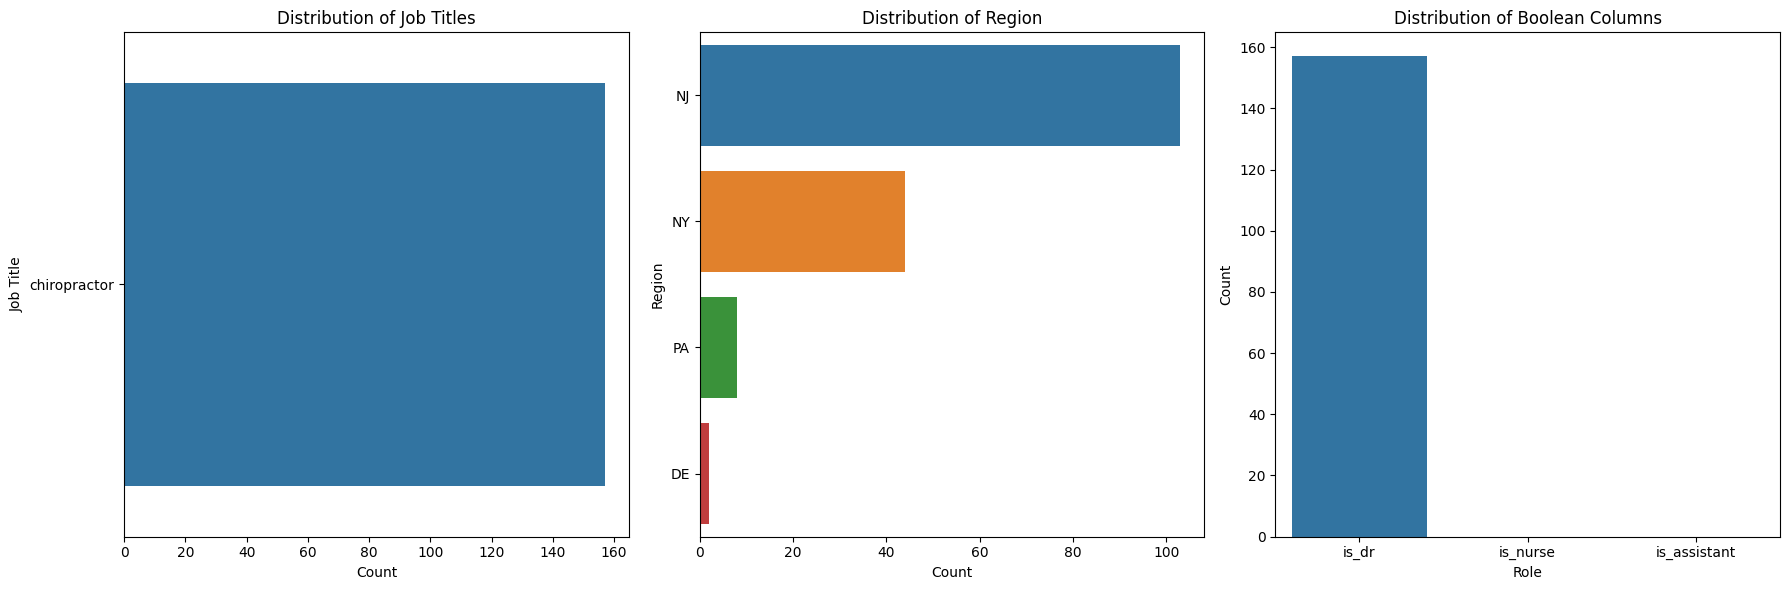

In [5]:
df_chiropractor = clean_dataset(dataset_paths[2], 'chiropractor', keywords='chiro')
df_chiropractor.info()
check_plots(df_chiropractor)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Dentist    155
Name: count, dtype: int64

[After] Job title unique values: job_title
dentist    155
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              155 non-null    object 
 1   job_title         155 non-null    object 
 2   rating            150 non-null    float64
 3   street_address    155 non-null    object 
 4   address_locality  154 non-null    object 
 5   region            155 non-null    object 
 6   postal_code       155 non-null    int64  
 7   is_dr             155 non-null    int64  
 8   is_nurse          155 non-null    int64  
 9   is_assistant      155 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 12.2+ KB


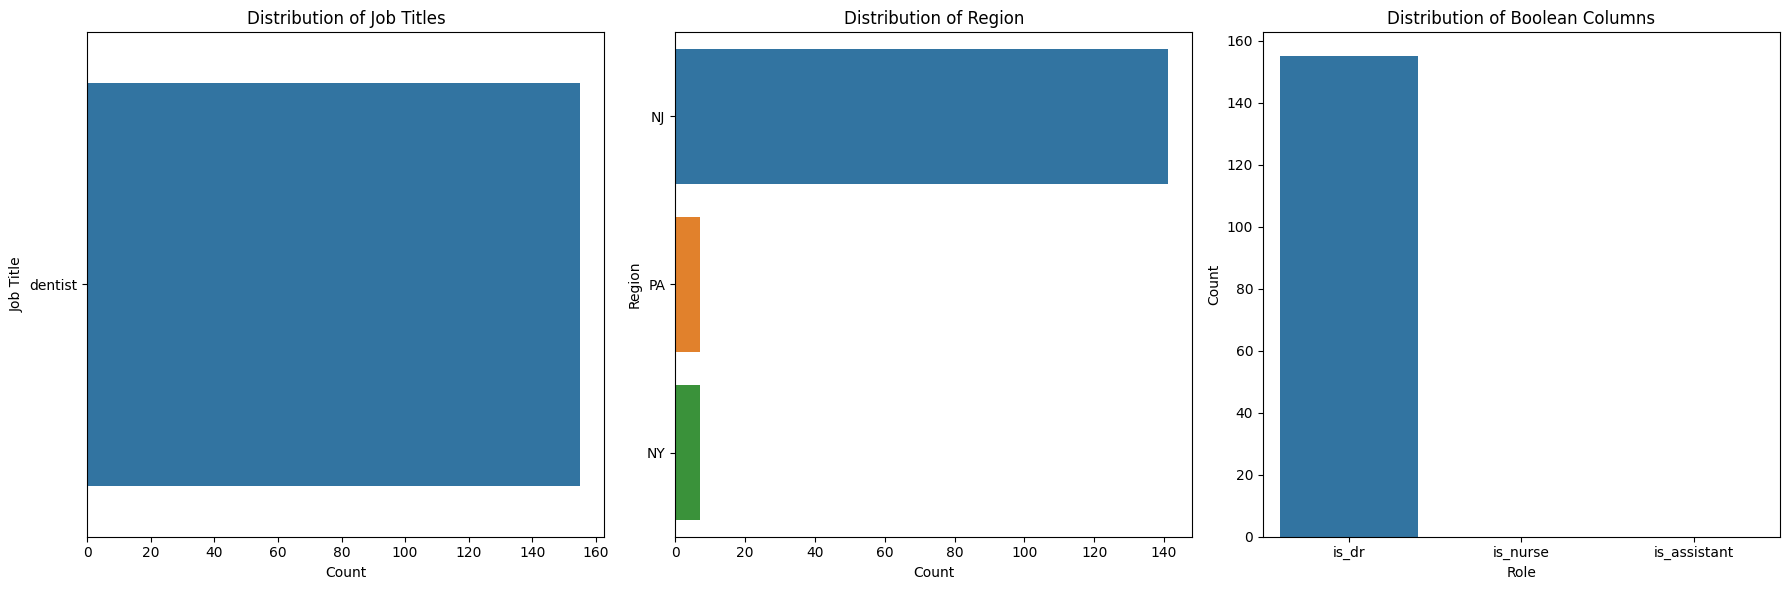

In [6]:
df_dentist = clean_dataset(dataset_paths[3], 'dentist', keywords='dent')
df_dentist.info()
check_plots(df_dentist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Physician Assistant (Dermatology)    68
Dermatologist                        57
Nurse Practitioner (Dermatology)     43
Dermatology Nurse Practitioner        2
Name: count, dtype: int64

[After] Job title unique values: job_title
dermatologist    170
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              170 non-null    object 
 1   job_title         170 non-null    object 
 2   rating            169 non-null    float64
 3   street_address    170 non-null    object 
 4   address_locality  170 non-null    object 
 5   region            170 non-null    object 
 6   postal_code       170 non-null    int64  
 7   is_dr             170 non-null    int64  
 8   is_nurse          170 non-null    int64  
 9   is_assistant     

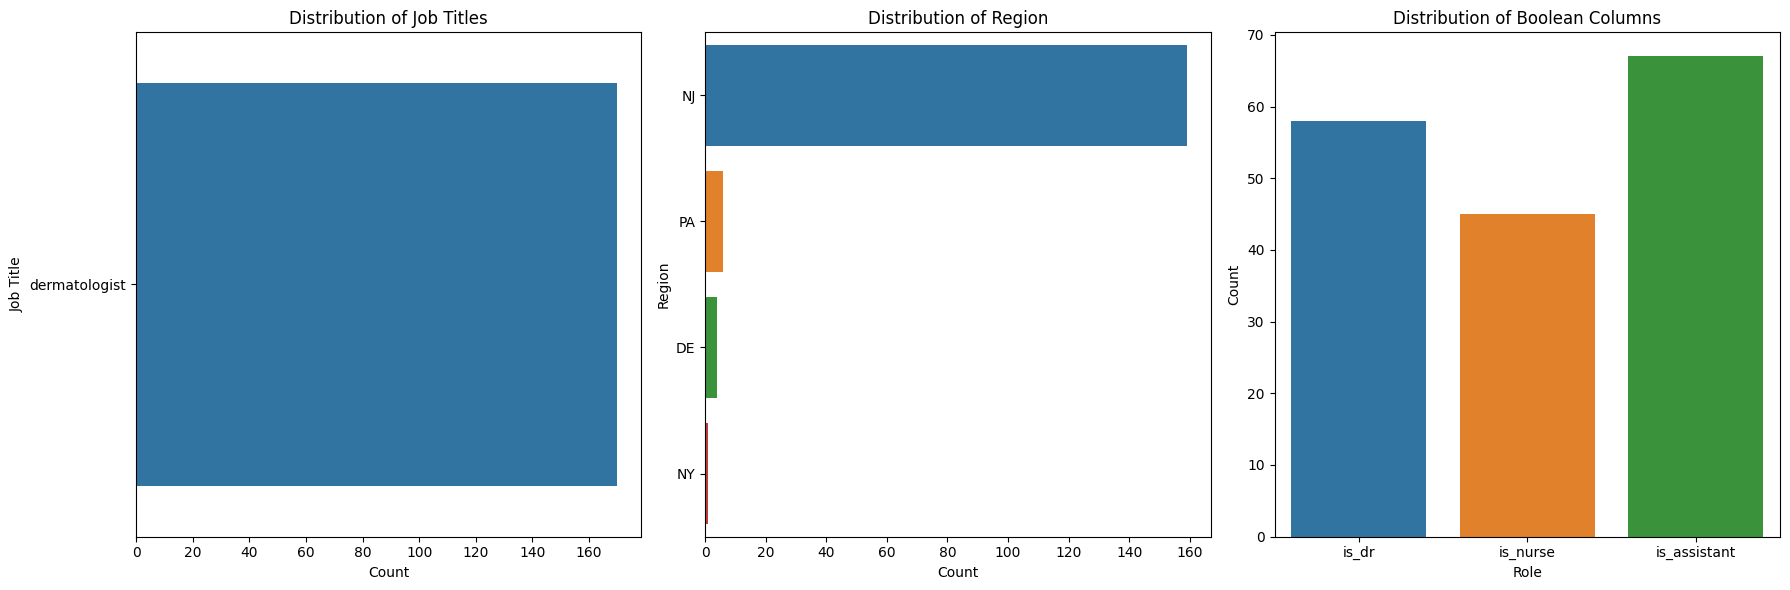

In [7]:
df_dermatologist = clean_dataset(dataset_paths[4], 'dermatologist',  keywords='dermat')
df_dermatologist.info()
check_plots(df_dermatologist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Dietitian    2
Name: count, dtype: int64

[After] Job title unique values: job_title
dietitian    2
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2 non-null      object 
 1   job_title         2 non-null      object 
 2   rating            2 non-null      float64
 3   street_address    2 non-null      object 
 4   address_locality  0 non-null      object 
 5   region            2 non-null      object 
 6   postal_code       2 non-null      int64  
 7   is_dr             2 non-null      int64  
 8   is_nurse          2 non-null      int64  
 9   is_assistant      2 non-null      int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 288.0+ bytes


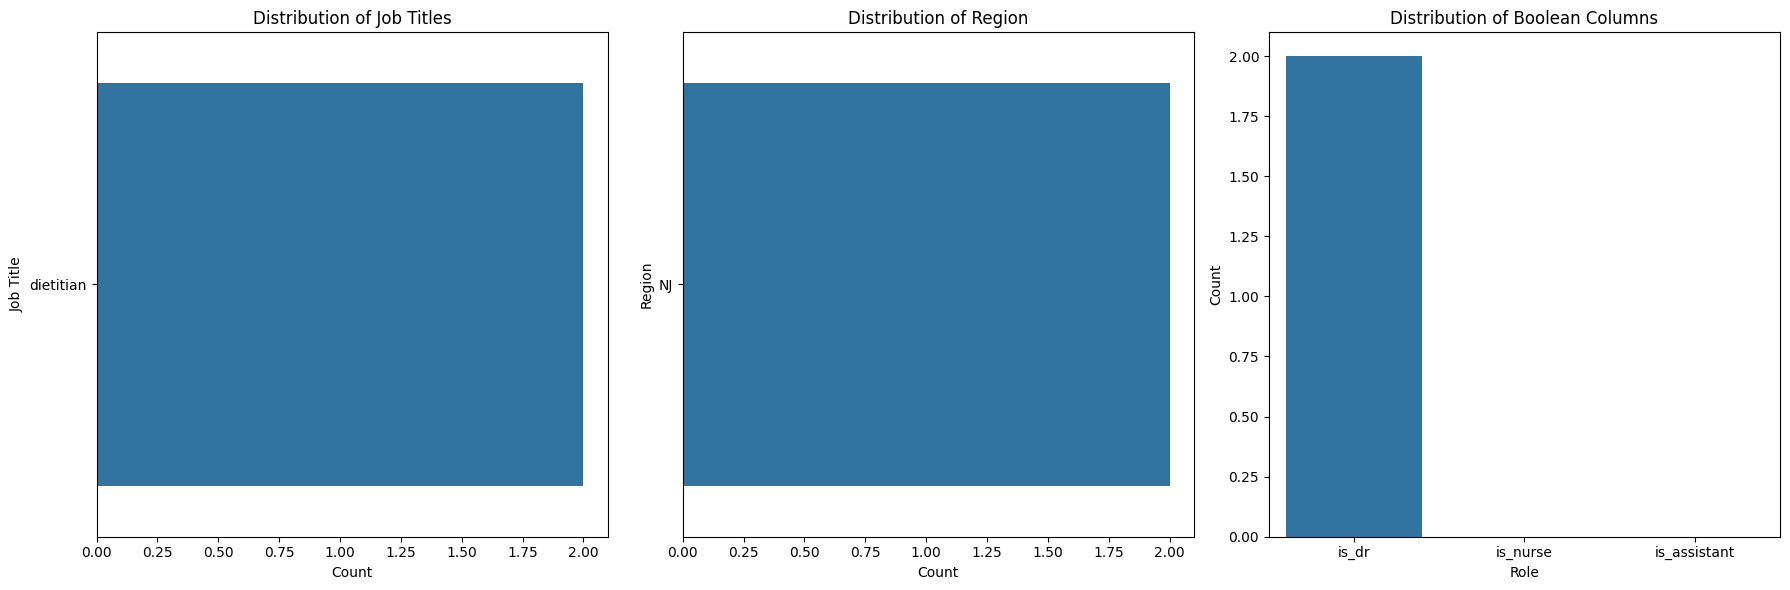

In [8]:
df_dietitian = clean_dataset(dataset_paths[5], 'dietitian', keywords='diet')
df_dietitian.info()
check_plots(df_dietitian)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Ear, Nose & Throat Doctor         60
Internist                         30
Family Nurse Practitioner         12
Physician Assistant (ENT)         10
Nurse Practitioner                 6
Adult Nurse Practitioner           5
Gerontology Nurse Practitioner     5
Physician Assistant                1
Name: count, dtype: int64

[After] Job title unique values: job_title
ent    129
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              129 non-null    object 
 1   job_title         129 non-null    object 
 2   rating            116 non-null    float64
 3   street_address    129 non-null    object 
 4   address_locality  121 non-null    object 
 5   region            129 non-null    object 
 6   postal_code       129 non-null  

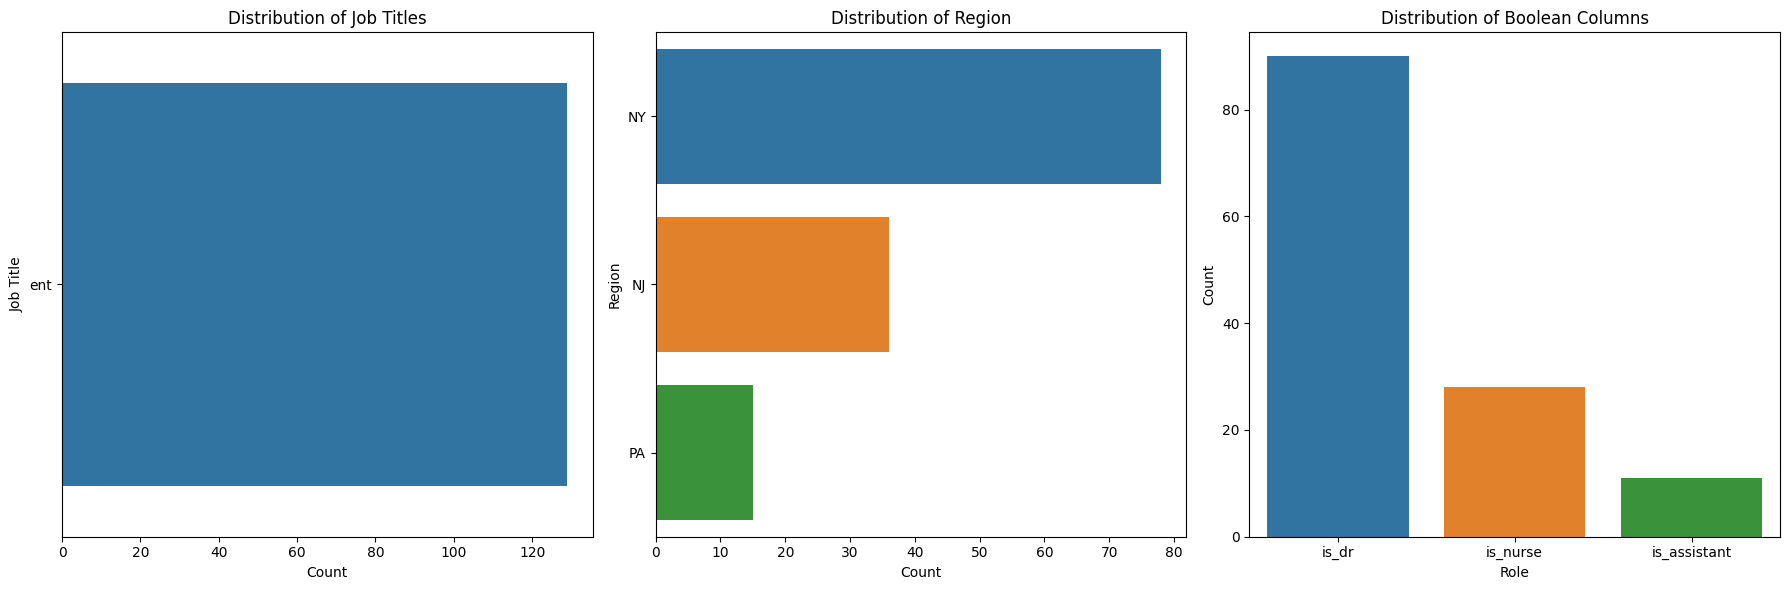

In [9]:
df_ent = clean_dataset(dataset_paths[6], 'ent', keywords='ear|nose|throat')
df_ent.info()
check_plots(df_ent)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Gastroenterologist           149
Family Nurse Practitioner      2
Nurse Practitioner             2
Internist                      1
Adult Nurse Practitioner       1
Name: count, dtype: int64

[After] Job title unique values: job_title
gastroenterologist    155
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              155 non-null    object 
 1   job_title         155 non-null    object 
 2   rating            153 non-null    float64
 3   street_address    155 non-null    object 
 4   address_locality  154 non-null    object 
 5   region            155 non-null    object 
 6   postal_code       155 non-null    int64  
 7   is_dr             155 non-null    int64  
 8   is_nurse          155 non-null    int64  
 9   is_assi

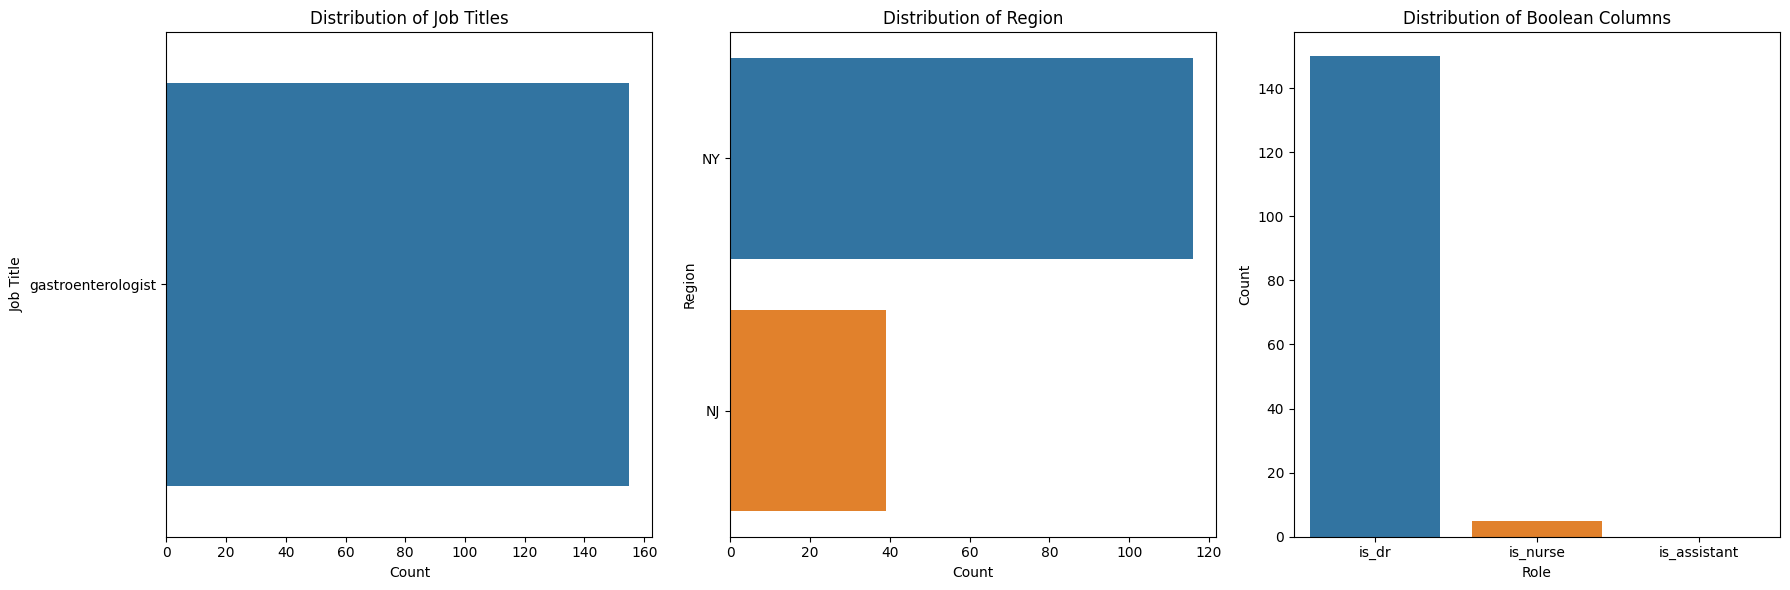

In [10]:
df_gastroenterologist = clean_dataset(dataset_paths[7], 'gastroenterologist', keywords='gas')
df_gastroenterologist.info()
check_plots(df_gastroenterologist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Neurosurgeon    32
Name: count, dtype: int64

[After] Job title unique values: job_title
neurosurgeon    32
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              32 non-null     object 
 1   job_title         32 non-null     object 
 2   rating            30 non-null     float64
 3   street_address    32 non-null     object 
 4   address_locality  32 non-null     object 
 5   region            32 non-null     object 
 6   postal_code       32 non-null     int64  
 7   is_dr             32 non-null     int64  
 8   is_nurse          32 non-null     int64  
 9   is_assistant      32 non-null     int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 2.6+ KB


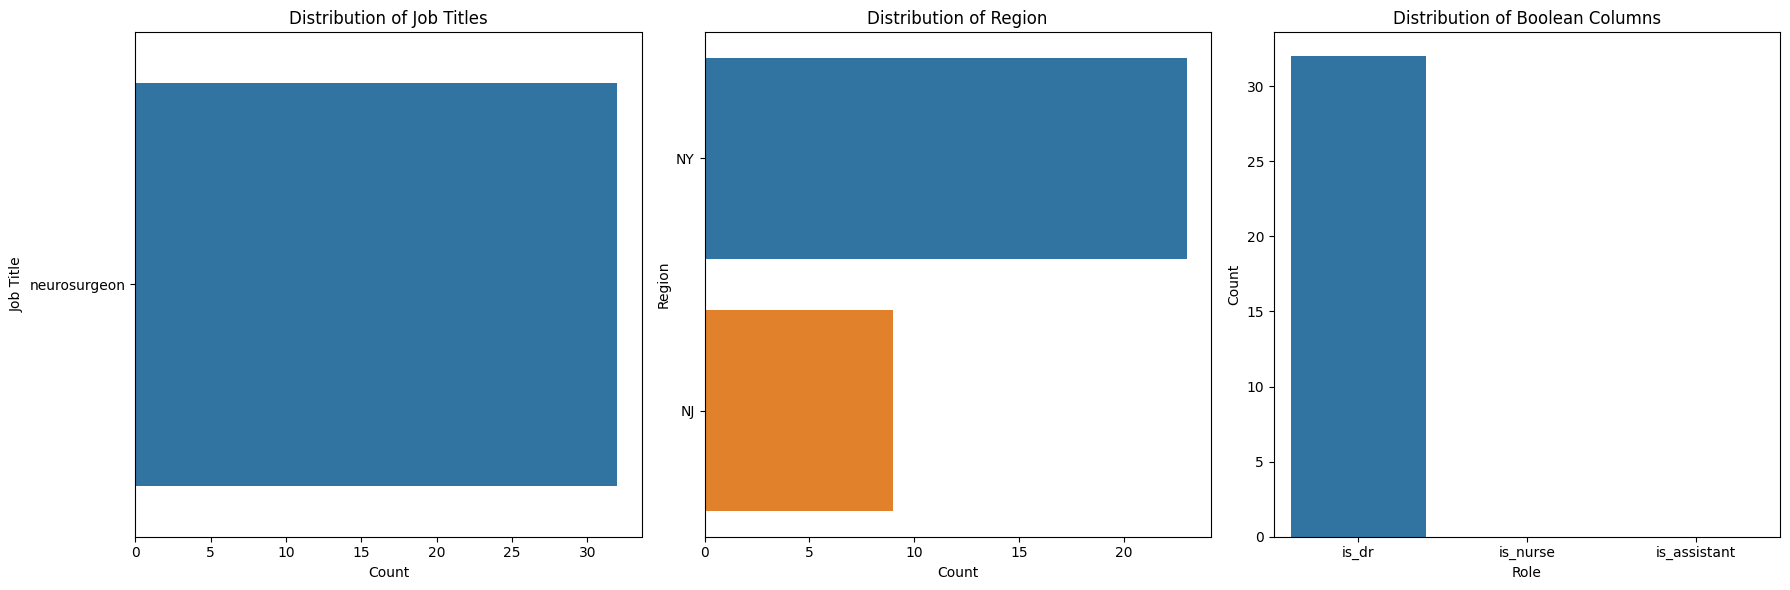

In [11]:
df_neurosurgeon = clean_dataset(dataset_paths[8], 'neurosurgeon', keywords='neuro')
df_neurosurgeon.info()
check_plots(df_neurosurgeon)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
OB-GYN                               99
Gynecologist                         16
Physician Assistant                   9
Physician Assistant (OB-GYN)          8
Nurse Practitioner (OB-GYN)           6
Women's Health Nurse Practitioner     5
OB-GYN Nurse Practitioner             4
Nurse Practitioner                    4
Family Nurse Practitioner             4
Adult Nurse Practitioner              2
Urogynecologist                       1
Internist                             1
Name: count, dtype: int64

[After] Job title unique values: job_title
ob-gyn    159
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              159 non-null    object 
 1   job_title         159 non-null    object 
 2   rating            157 non-null   

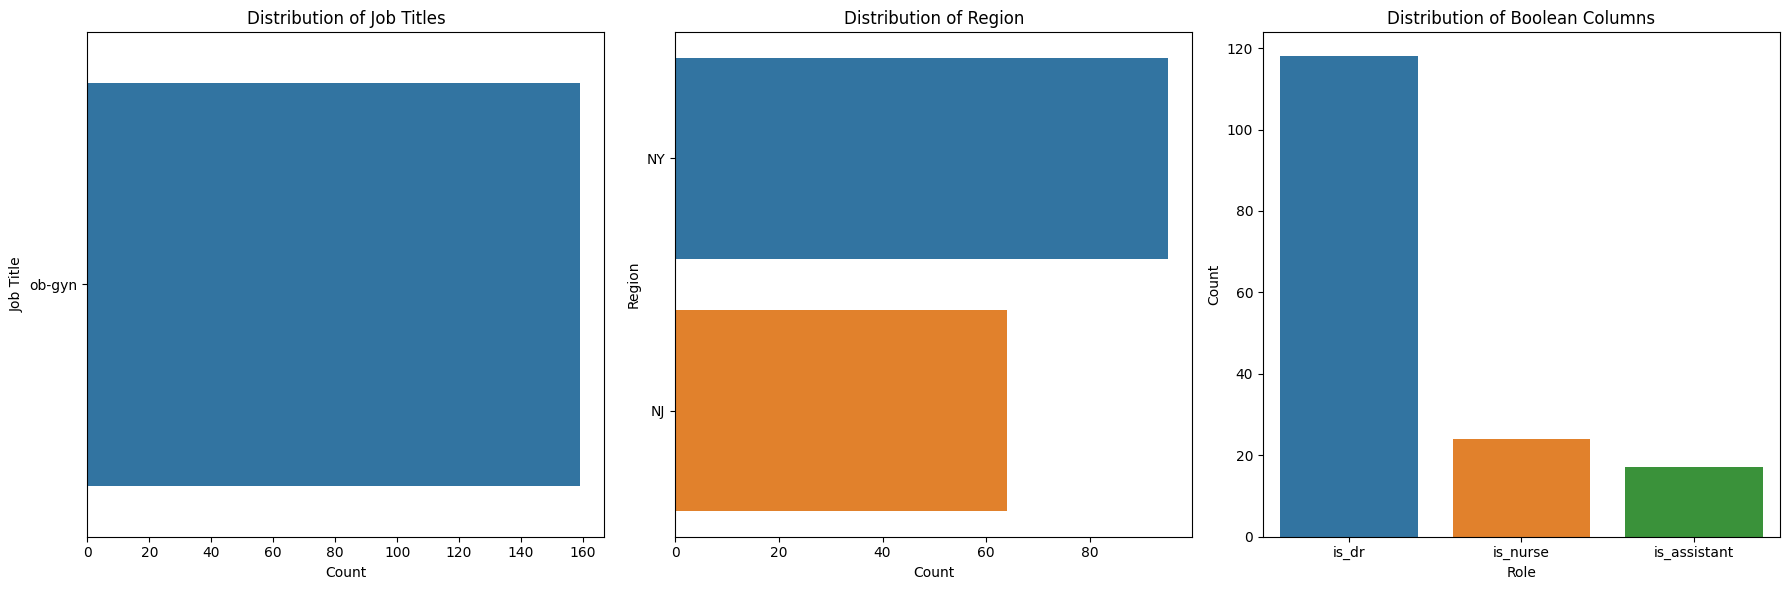

In [12]:
df_obgyn = clean_dataset(dataset_paths[9], 'ob-gyn', keywords='gyn|ob-gyn')
df_obgyn.info()
check_plots(df_obgyn)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Oncologist    44
Name: count, dtype: int64

[After] Job title unique values: job_title
oncologist    44
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              44 non-null     object 
 1   job_title         44 non-null     object 
 2   rating            44 non-null     float64
 3   street_address    44 non-null     object 
 4   address_locality  44 non-null     object 
 5   region            44 non-null     object 
 6   postal_code       44 non-null     int64  
 7   is_dr             44 non-null     int64  
 8   is_nurse          44 non-null     int64  
 9   is_assistant      44 non-null     int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 3.6+ KB


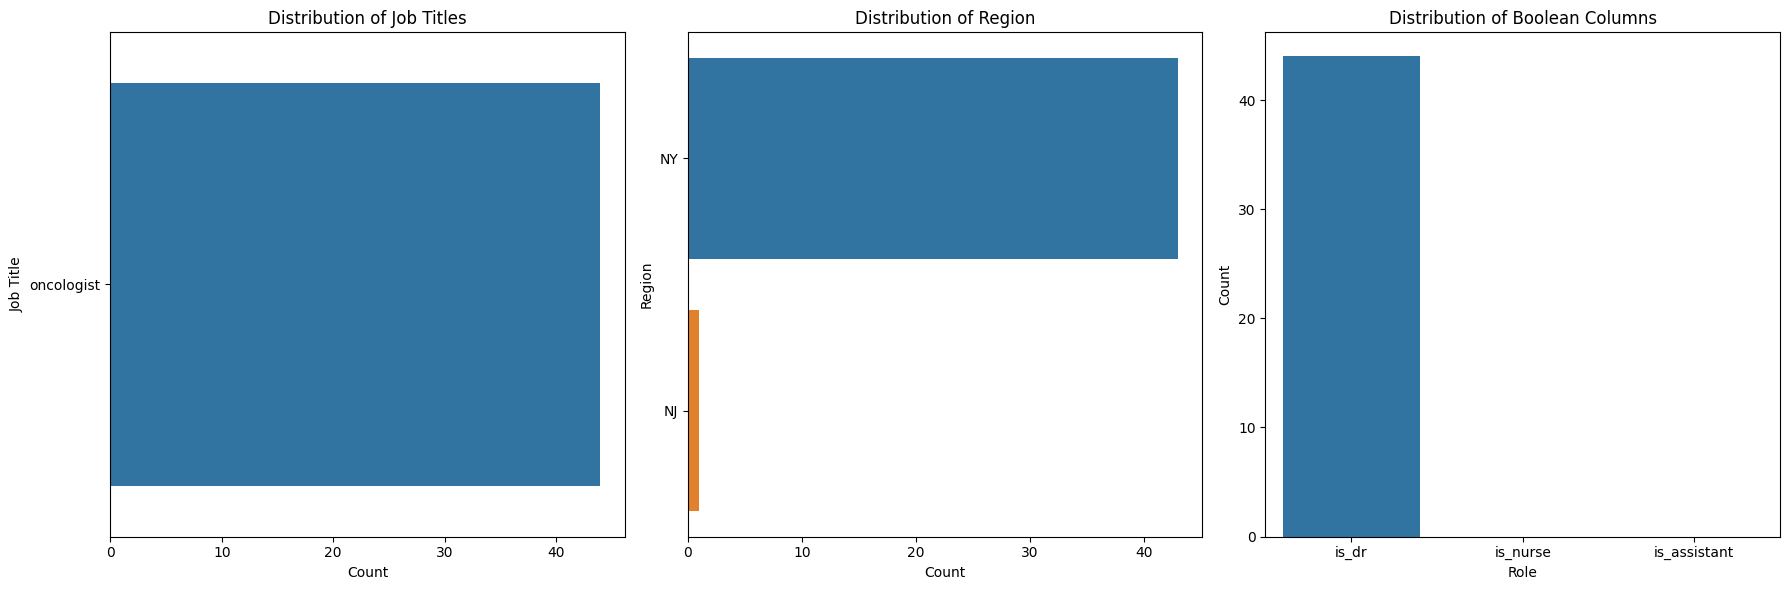

In [13]:
df_oncologist = clean_dataset(dataset_paths[10], 'oncologist', keywords='oncolo')
df_oncologist.info()
check_plots(df_oncologist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Optometrist    115
Name: count, dtype: int64

[After] Job title unique values: job_title
optometrist    115
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              115 non-null    object 
 1   job_title         115 non-null    object 
 2   rating            113 non-null    float64
 3   street_address    115 non-null    object 
 4   address_locality  115 non-null    object 
 5   region            115 non-null    object 
 6   postal_code       115 non-null    int64  
 7   is_dr             115 non-null    int64  
 8   is_nurse          115 non-null    int64  
 9   is_assistant      115 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 9.1+ KB


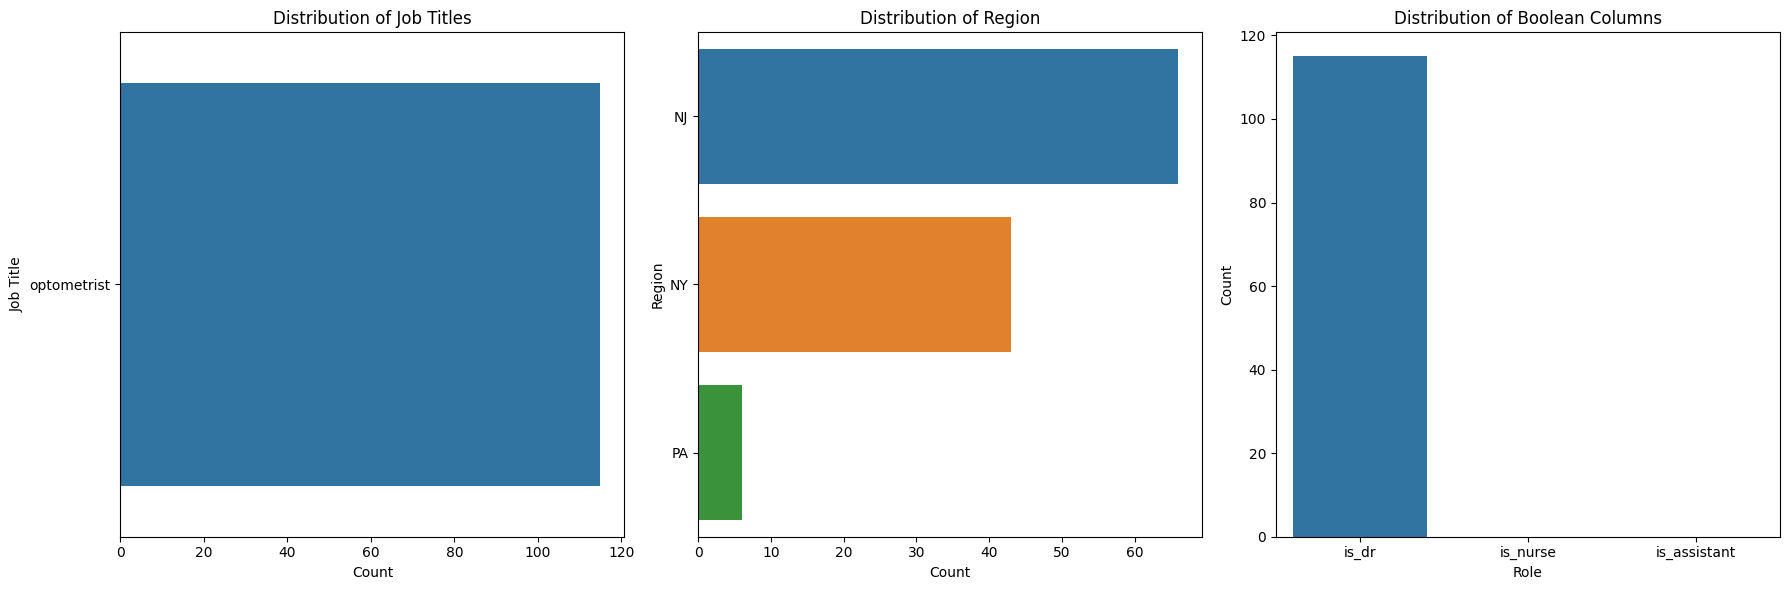

In [14]:
df_optometrist = clean_dataset(dataset_paths[11], 'optometrist', keywords='optome')
df_optometrist.info()
check_plots(df_optometrist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Orthopedic Surgeon                   96
Physician Assistant (Orthopedics)     9
Physician Assistant                   1
Name: count, dtype: int64

[After] Job title unique values: job_title
orthopedic    106
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              106 non-null    object 
 1   job_title         106 non-null    object 
 2   rating            104 non-null    float64
 3   street_address    106 non-null    object 
 4   address_locality  103 non-null    object 
 5   region            106 non-null    object 
 6   postal_code       106 non-null    int64  
 7   is_dr             106 non-null    int64  
 8   is_nurse          106 non-null    int64  
 9   is_assistant      106 non-null    int64  
dtypes: float64(1)

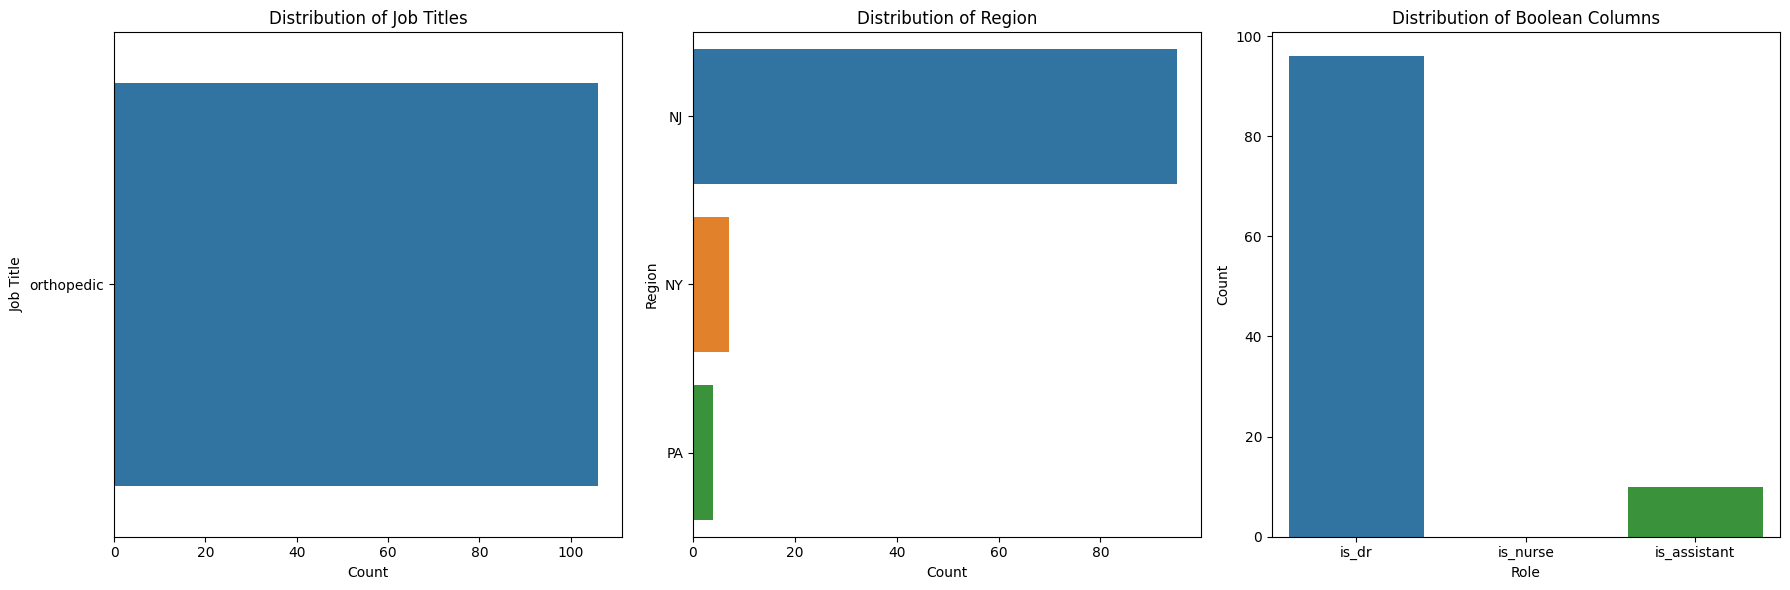

In [15]:
df_orthopedic = clean_dataset(dataset_paths[12], 'orthopedic', keywords='ortho')
df_orthopedic.info()
check_plots(df_orthopedic)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Orthopedic Surgeon                   117
Physician Assistant (Orthopedics)      9
Nurse Practitioner (Orthopedics)       2
Name: count, dtype: int64

[After] Job title unique values: job_title
orthopedic_surgeon    128
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              128 non-null    object 
 1   job_title         128 non-null    object 
 2   rating            126 non-null    float64
 3   street_address    128 non-null    object 
 4   address_locality  126 non-null    object 
 5   region            128 non-null    object 
 6   postal_code       128 non-null    int64  
 7   is_dr             128 non-null    int64  
 8   is_nurse          128 non-null    int64  
 9   is_assistant      128 non-null    int64  
dtypes:

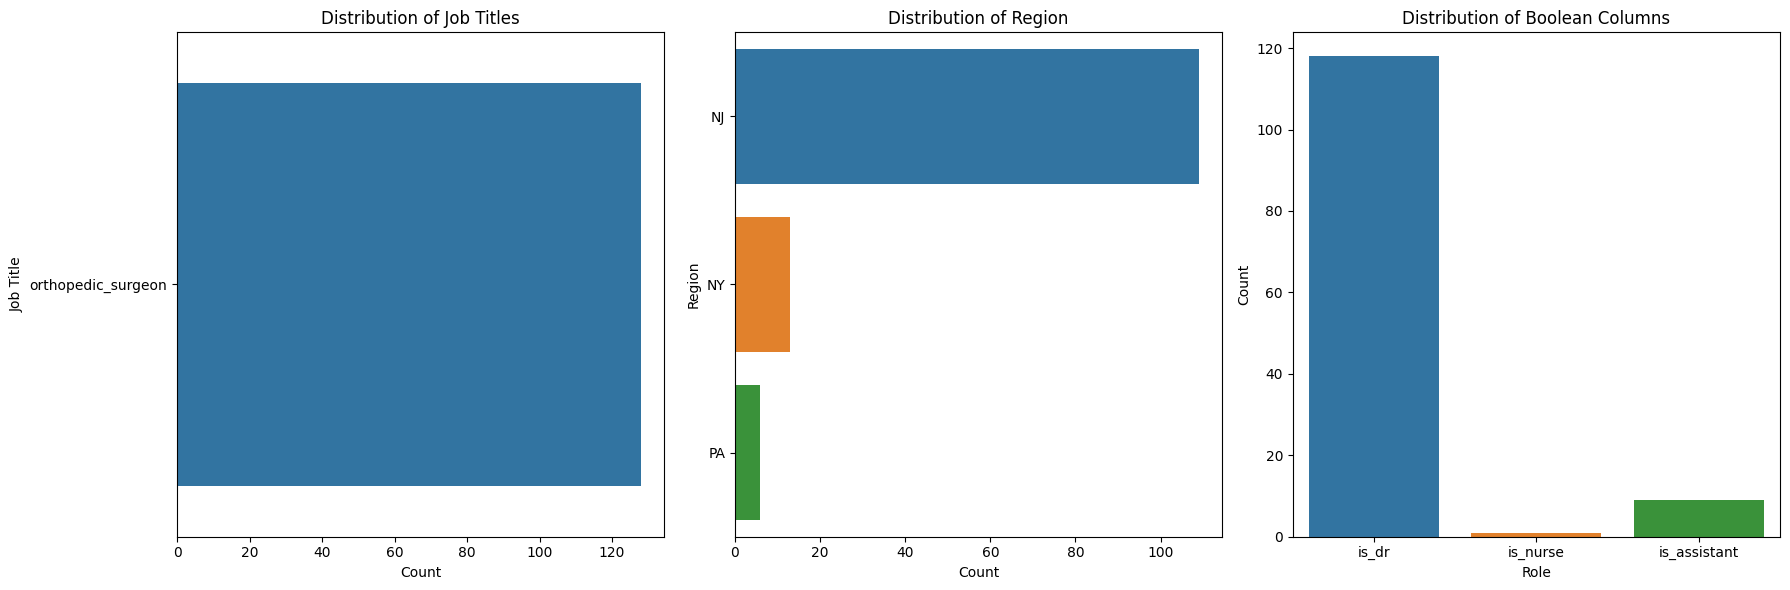

In [16]:
df_orthopedic_surgeon = clean_dataset(dataset_paths[13], 'orthopedic_surgeon', keywords='ortho|surg')
df_orthopedic_surgeon.info()
check_plots(df_orthopedic_surgeon)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Pain Management Specialist                              86
Physician Assistant                                      3
Nurse Practitioner                                       2
Physician Assistant (Orthopedics)                        2
Internist                                                1
Family Nurse Practitioner                                1
Adult Psychiatric & Mental Health Nurse Practitioner     1
Nurse Practitioner (Psychiatry)                          1
Adult Nurse Practitioner                                 1
Name: count, dtype: int64

[After] Job title unique values: job_title
pain_management    98
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              98 non-null     object 
 1   job_title         98 no

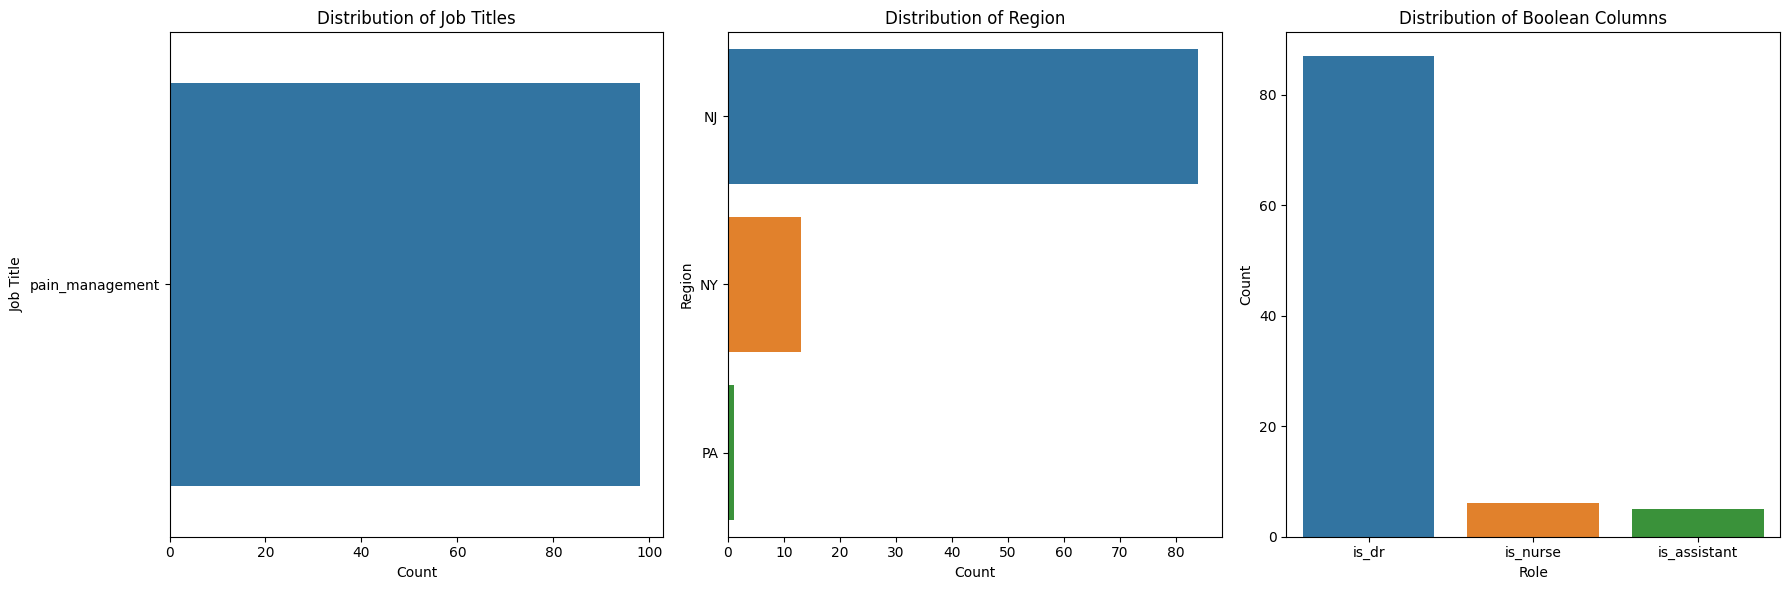

In [17]:
df_pain_management = clean_dataset(dataset_paths[14], 'pain_management', keywords='pain')
df_pain_management.info()
check_plots(df_pain_management)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Physical Therapist                   73
Physician Assistant (Orthopedics)     3
Physiatrist                           2
Internist                             1
Nurse Practitioner (Orthopedics)      1
Physician Assistant                   1
Nurse Practitioner                    1
Name: count, dtype: int64

[After] Job title unique values: job_title
physical_therapist    82
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              82 non-null     object 
 1   job_title         82 non-null     object 
 2   rating            71 non-null     float64
 3   street_address    82 non-null     object 
 4   address_locality  78 non-null     object 
 5   region            82 non-null     object 
 6   postal_code       82 non-null     in

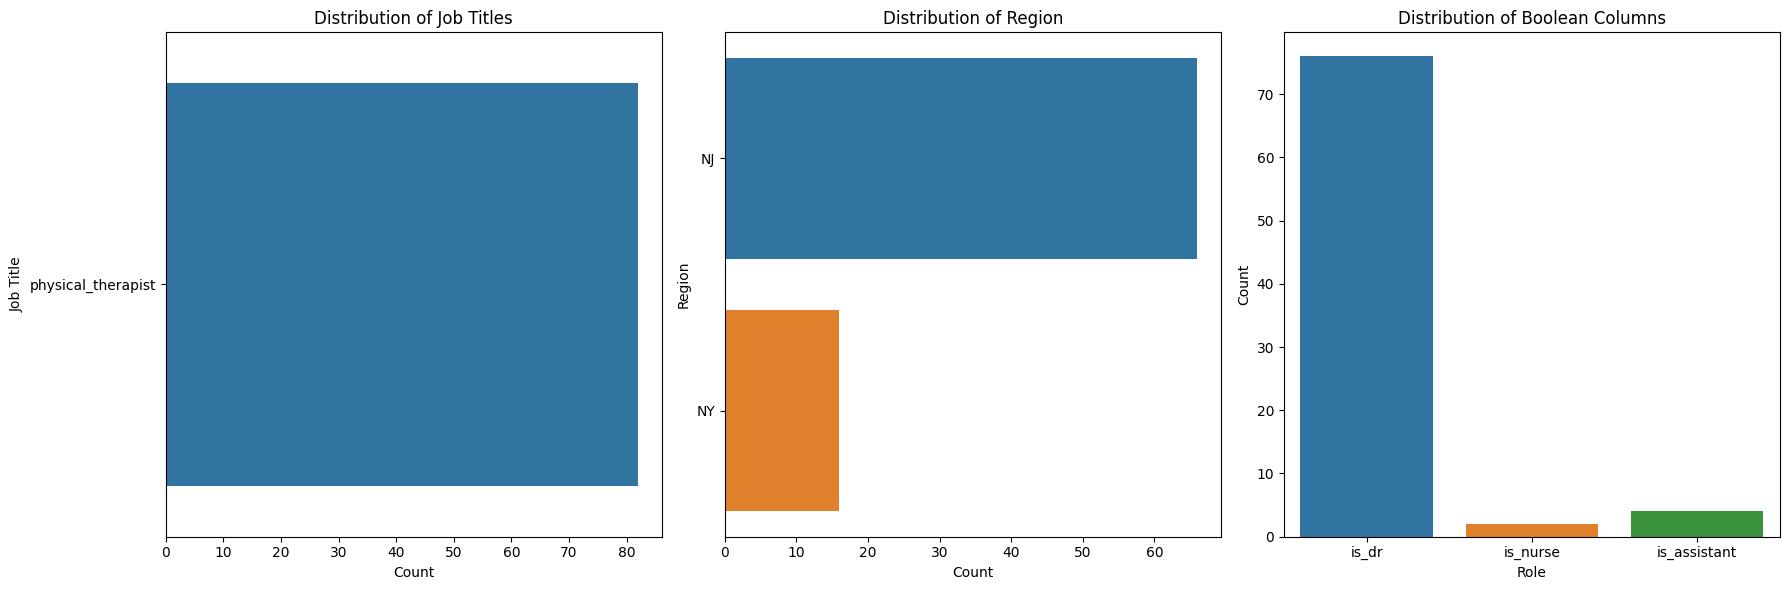

In [18]:
df_phy_therapist = clean_dataset(dataset_paths[15], 'physical_therapist', keywords='phy|ther')
df_phy_therapist.info()
check_plots(df_phy_therapist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Podiatrist    142
Internist       1
Name: count, dtype: int64

[After] Job title unique values: job_title
podiatrist    143
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              143 non-null    object 
 1   job_title         143 non-null    object 
 2   rating            141 non-null    float64
 3   street_address    143 non-null    object 
 4   address_locality  137 non-null    object 
 5   region            143 non-null    object 
 6   postal_code       143 non-null    int64  
 7   is_dr             143 non-null    int64  
 8   is_nurse          143 non-null    int64  
 9   is_assistant      143 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 11.3+ KB


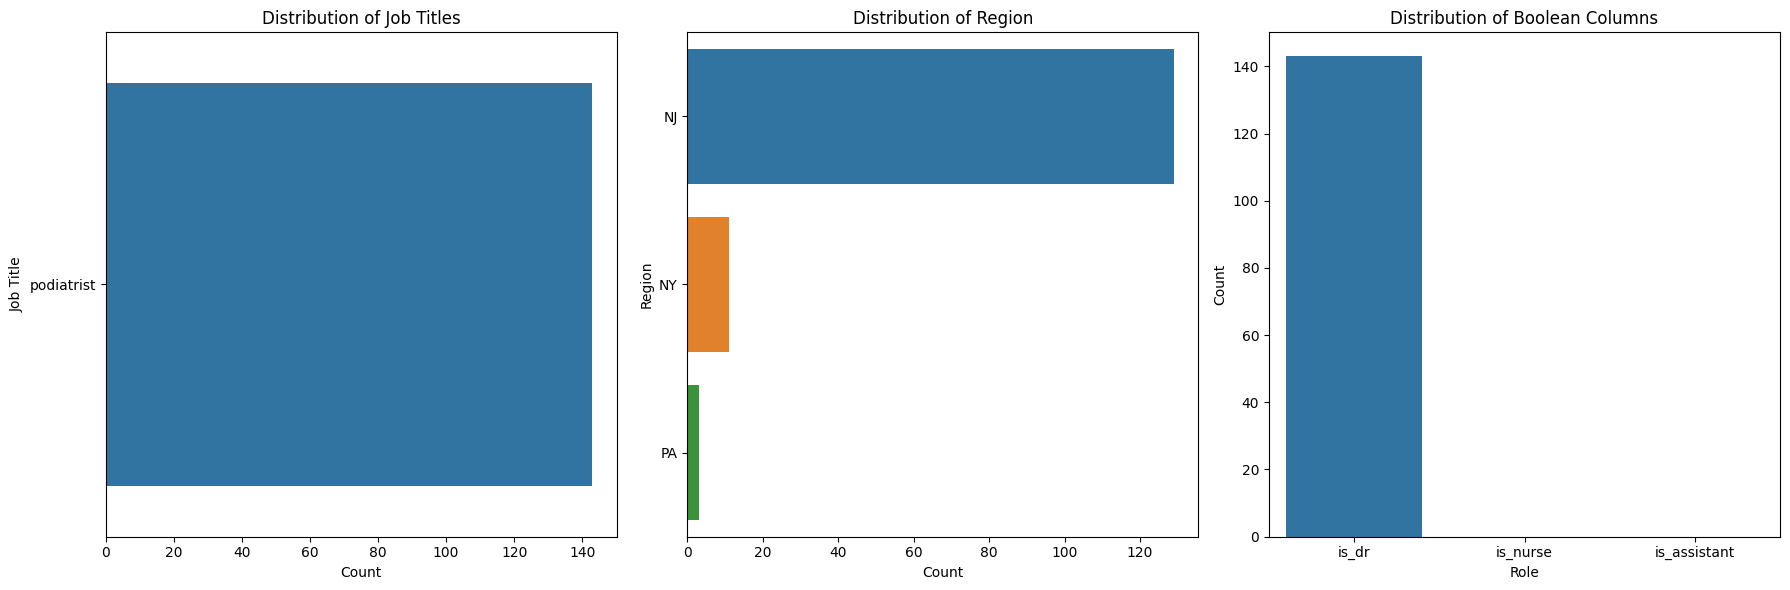

In [19]:
df_podiatrist = clean_dataset(dataset_paths[16], 'podiatrist', keywords='pod')
df_podiatrist.info()
check_plots(df_podiatrist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Primary Care Doctor                 97
Internist                           17
Nurse Practitioner                   9
Family Nurse Practitioner            9
Physician Assistant                  7
Adult Nurse Practitioner             2
Physician Assistant (Pediatrics)     1
Name: count, dtype: int64

[After] Job title unique values: job_title
pcd    142
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              142 non-null    object 
 1   job_title         142 non-null    object 
 2   rating            140 non-null    float64
 3   street_address    142 non-null    object 
 4   address_locality  111 non-null    object 
 5   region            142 non-null    object 
 6   postal_code       142 non-null    int64  
 7   is_dr   

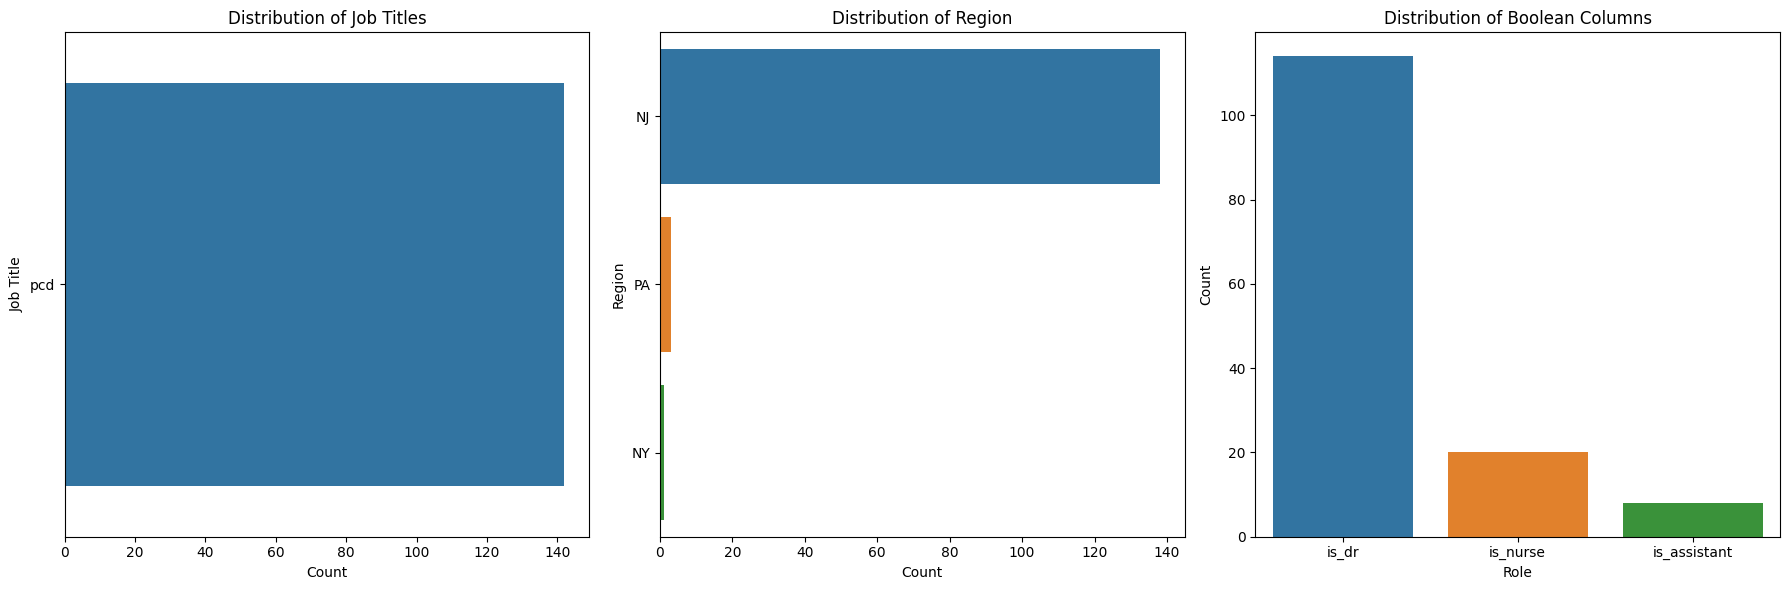

In [20]:
df_pcd = clean_dataset(dataset_paths[17], 'PCD', keywords='prim|care')
df_pcd.info()
check_plots(df_pcd)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Psychiatrist                                             53
Adult Psychiatric & Mental Health Nurse Practitioner     49
Nurse Practitioner (Psychiatry)                          25
Family Psychiatric & Mental Health Nurse Practitioner    22
Physician Assistant (Psychiatry)                          5
Psychologist                                              2
Mental Health Nurse Practitioner                          2
Adult Nurse Practitioner                                  1
Nurse Practitioner                                        1
Physician Assistant                                       1
Family Nurse Practitioner                                 1
Name: count, dtype: int64

[After] Job title unique values: job_title
psychiatrist    162
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 10 columns):
 #   Column            Non-Null Count  D

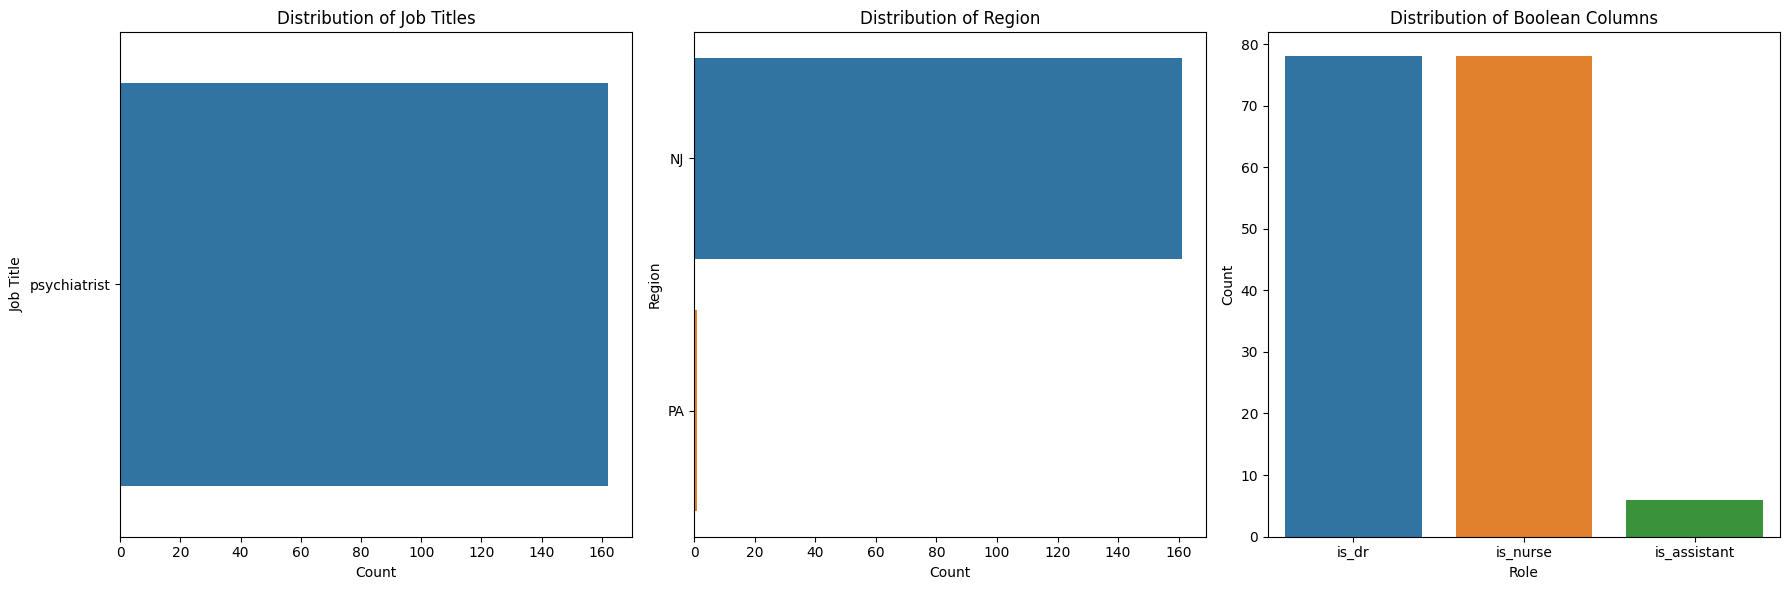

In [21]:
df_psychiatrist = clean_dataset(dataset_paths[18], 'psychiatrist', keywords='psych')
df_psychiatrist.info()
check_plots(df_psychiatrist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Rheumatologist                       16
Internist                             8
Physician Assistant (Orthopedics)     4
Family Nurse Practitioner             3
Physician Assistant                   2
Nurse Practitioner                    2
Name: count, dtype: int64

[After] Job title unique values: job_title
rheumatologist    35
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              35 non-null     object 
 1   job_title         35 non-null     object 
 2   rating            33 non-null     float64
 3   street_address    35 non-null     object 
 4   address_locality  33 non-null     object 
 5   region            35 non-null     object 
 6   postal_code       35 non-null     int64  
 7   is_dr             35 non-null    

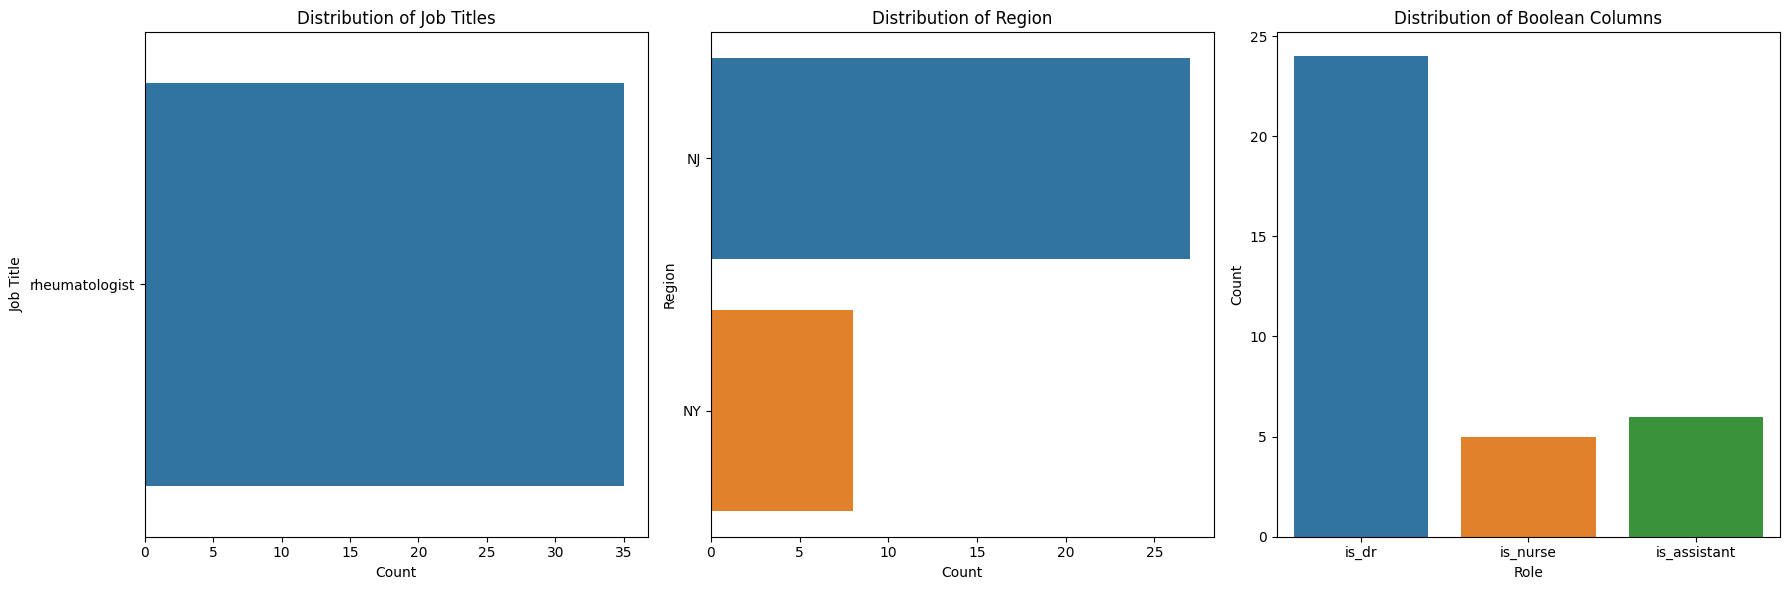

In [22]:
df_rheumatologist = clean_dataset(dataset_paths[19], 'rheumatologist', keywords='rheum')
df_rheumatologist.info()
check_plots(df_rheumatologist)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Physician Assistant (Orthopedics)    3
Physician Assistant                  2
Internist                            1
Nurse Practitioner (Orthopedics)     1
Physician Assistant (Pediatrics)     1
Nurse Practitioner                   1
Name: count, dtype: int64

[After] Job title unique values: job_title
sports_medicine    9
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              9 non-null      object 
 1   job_title         9 non-null      object 
 2   rating            9 non-null      float64
 3   street_address    9 non-null      object 
 4   address_locality  9 non-null      object 
 5   region            9 non-null      object 
 6   postal_code       9 non-null      int64  
 7   is_dr             9 non-null      int64  

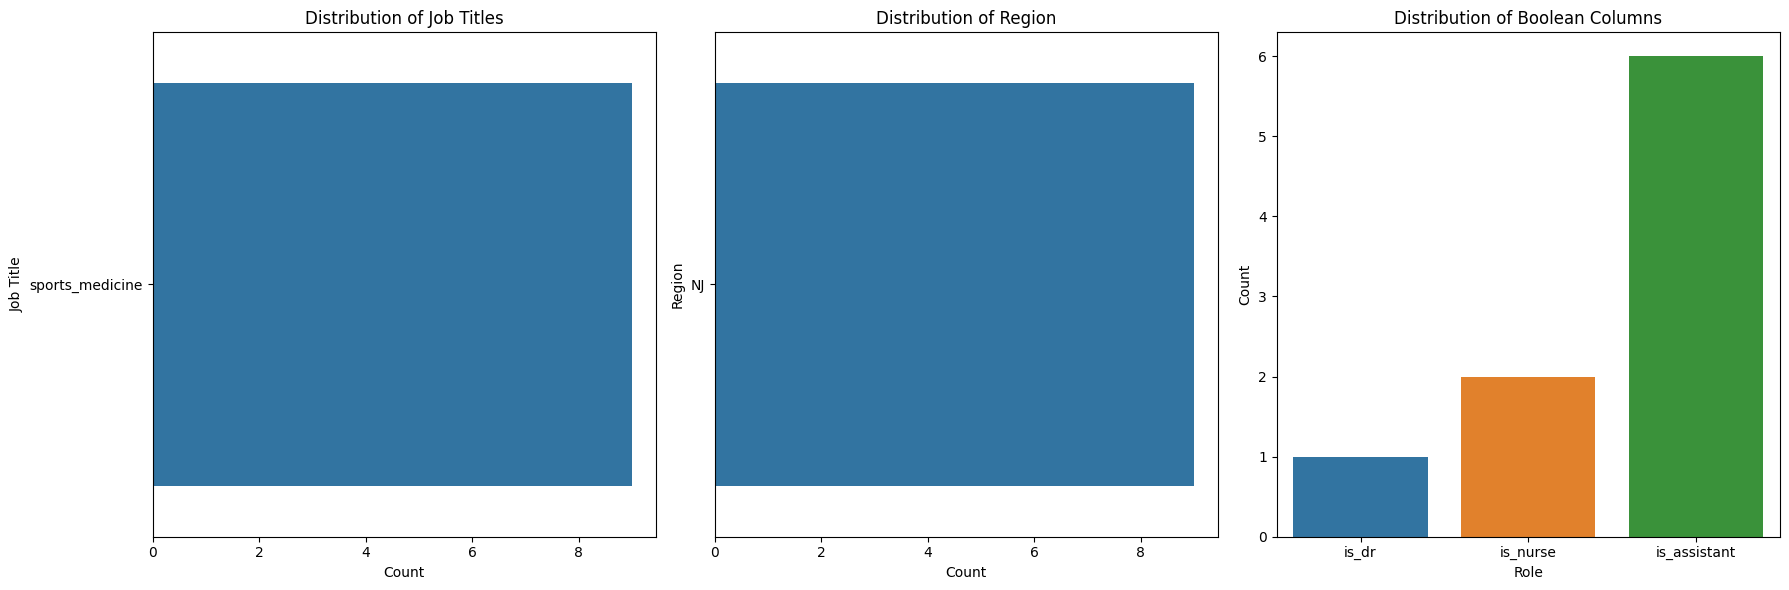

In [23]:
df_sports_medicine = clean_dataset(dataset_paths[20], 'sports_medicine', keywords='rheum')
df_sports_medicine.info()
check_plots(df_sports_medicine)

Count non-assigned status rows: 0

[Before] Job title unique values: job_title
Surgeon                              41
Orthopedic Surgeon                   12
Bariatric Surgeon                     8
Spine Surgeon                         5
Shoulder & Elbow Surgeon              3
Physician Assistant (Orthopedics)     2
Hand Surgeon                          1
Pediatric Orthopedic Surgeon          1
Name: count, dtype: int64

[After] Job title unique values: job_title
surgeon    73
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              73 non-null     object 
 1   job_title         73 non-null     object 
 2   rating            71 non-null     float64
 3   street_address    73 non-null     object 
 4   address_locality  72 non-null     object 
 5   region            73 non-null     object 
 6   postal_

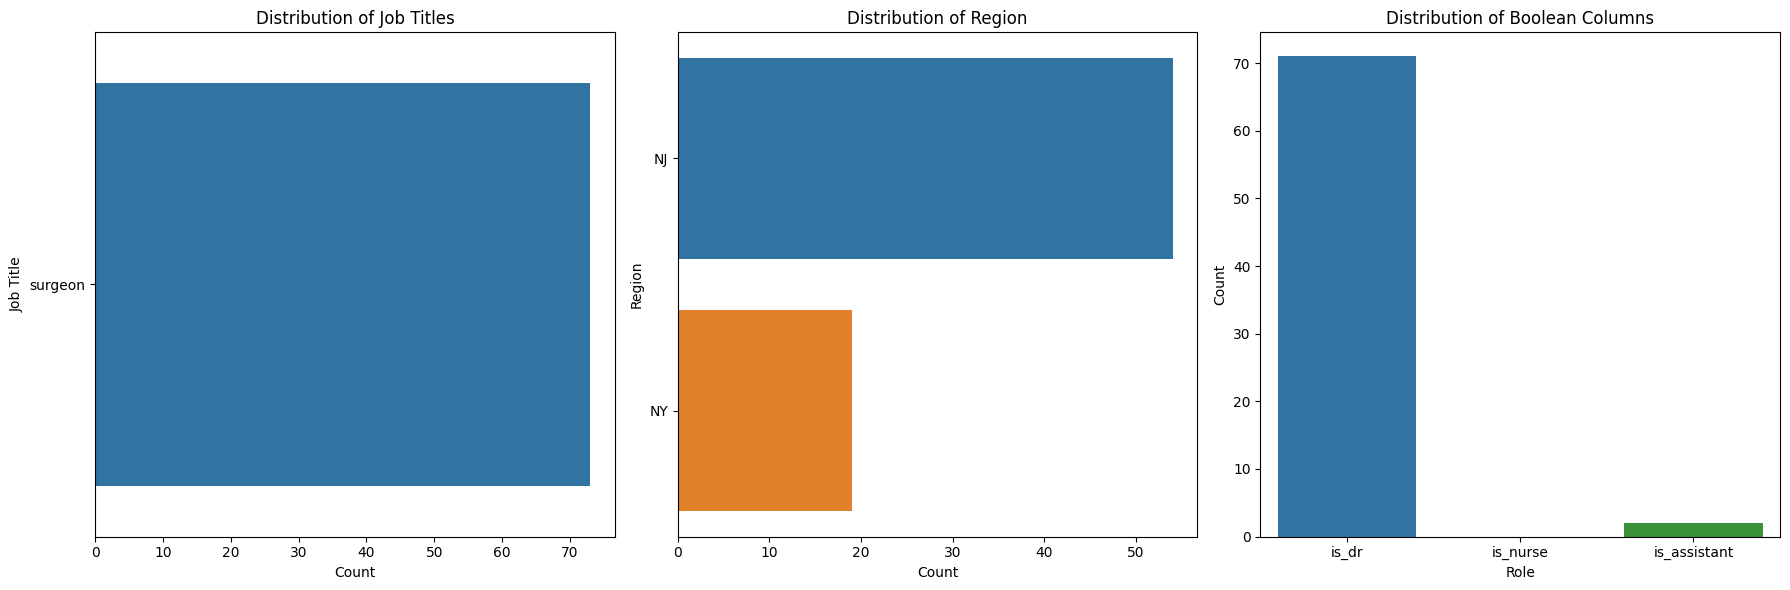

In [24]:
df_surgeon = clean_dataset(dataset_paths[21], 'surgeon', keywords='surgeon')
df_surgeon.info()
check_plots(df_surgeon)

In [25]:
df_combined = pd.concat([df_cardiologist,
                         df_chiropractor,
                         df_dentist,
                         df_dermatologist,
                         df_dietitian,
                         df_ent,
                         df_gastroenterologist,
                         df_neurosurgeon,
                         df_obgyn,
                         df_oncologist,
                         df_optometrist,
                         df_orthopedic,
                         df_orthopedic_surgeon,
                         df_pain_management,
                         df_phy_therapist,
                         df_podiatrist,
                         df_pcd,
                         df_psychiatrist,
                         df_rheumatologist,
                         df_sports_medicine,
                         df_surgeon,
                        ])

In [26]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2249 entries, 0 to 72
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2249 non-null   object 
 1   job_title         2249 non-null   object 
 2   rating            2164 non-null   float64
 3   street_address    2249 non-null   object 
 4   address_locality  2025 non-null   object 
 5   region            2249 non-null   object 
 6   postal_code       2249 non-null   int64  
 7   is_dr             2249 non-null   int64  
 8   is_nurse          2249 non-null   int64  
 9   is_assistant      2249 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 193.3+ KB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

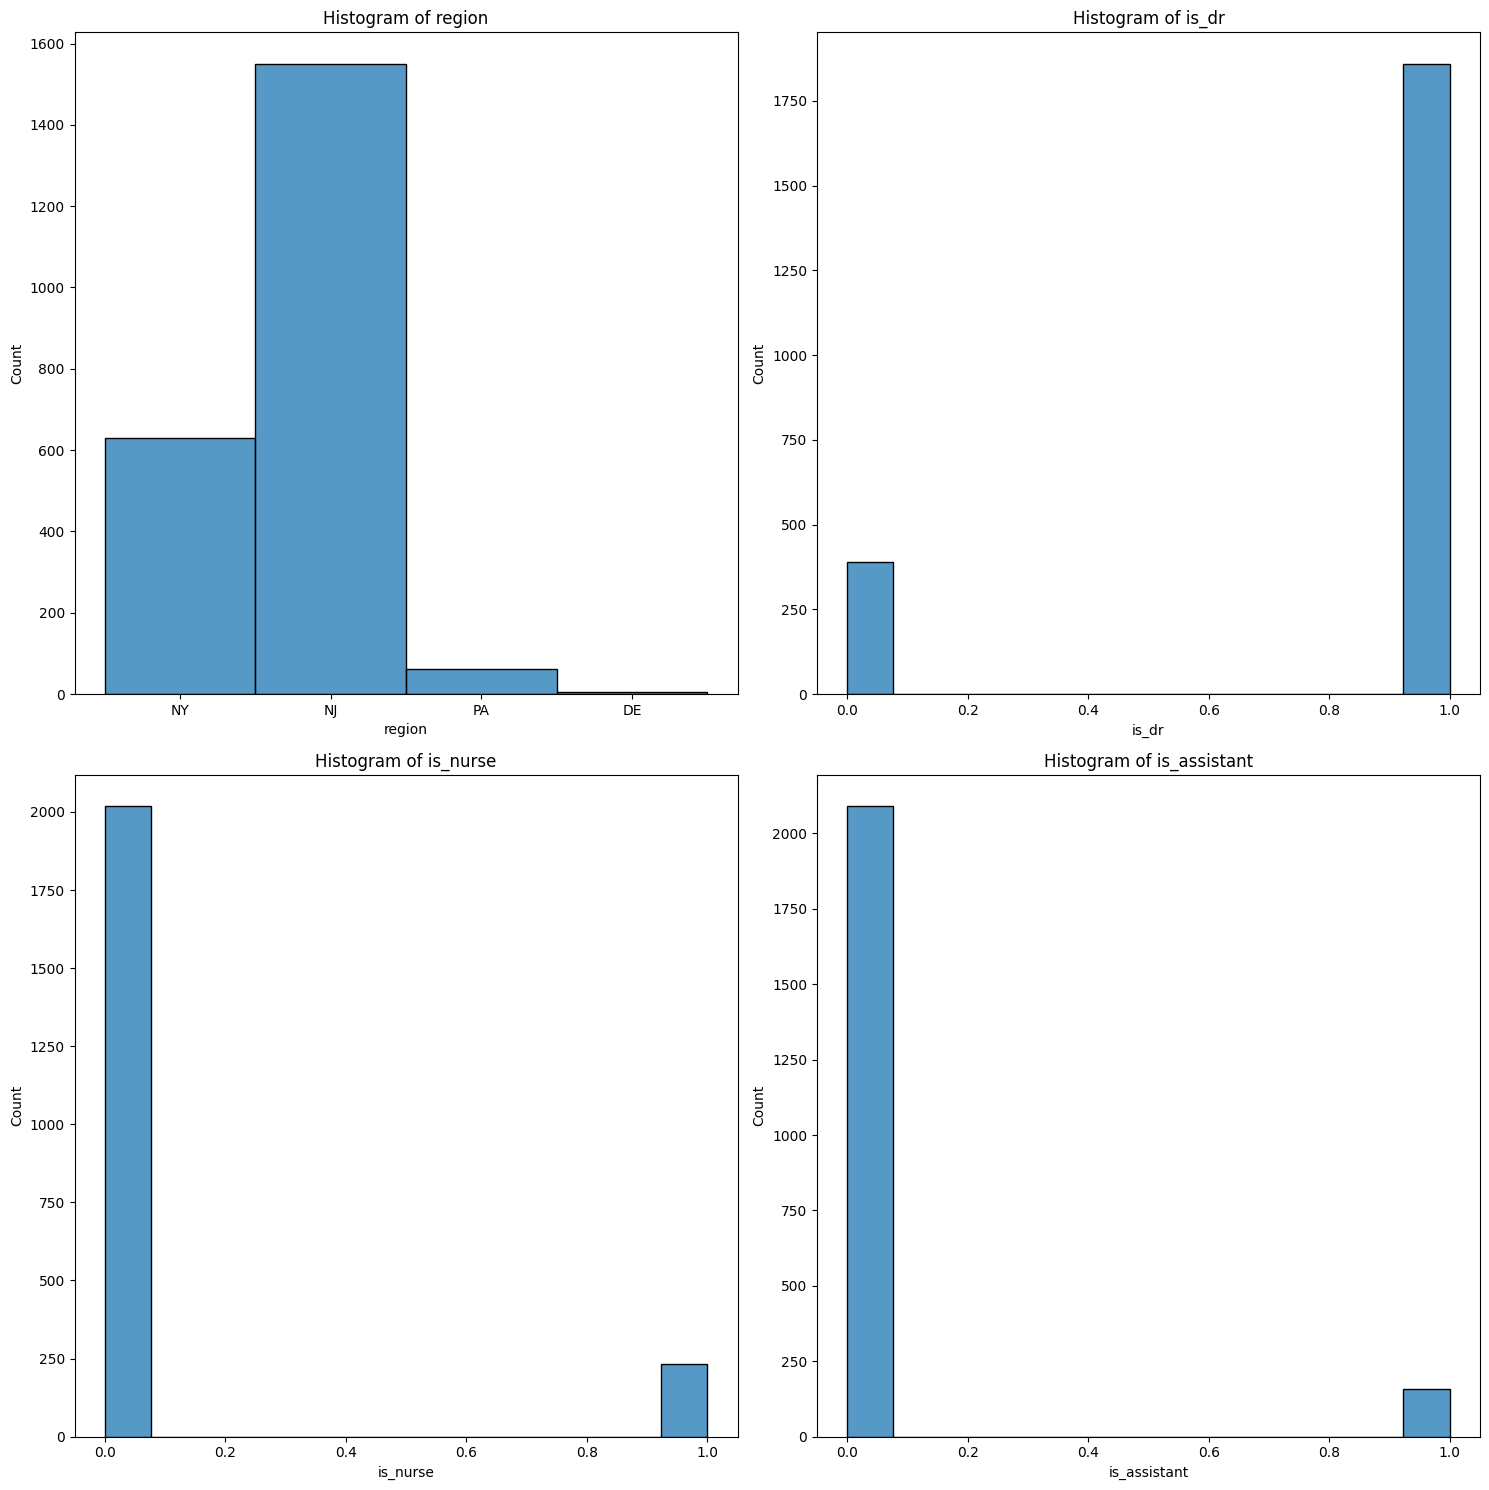

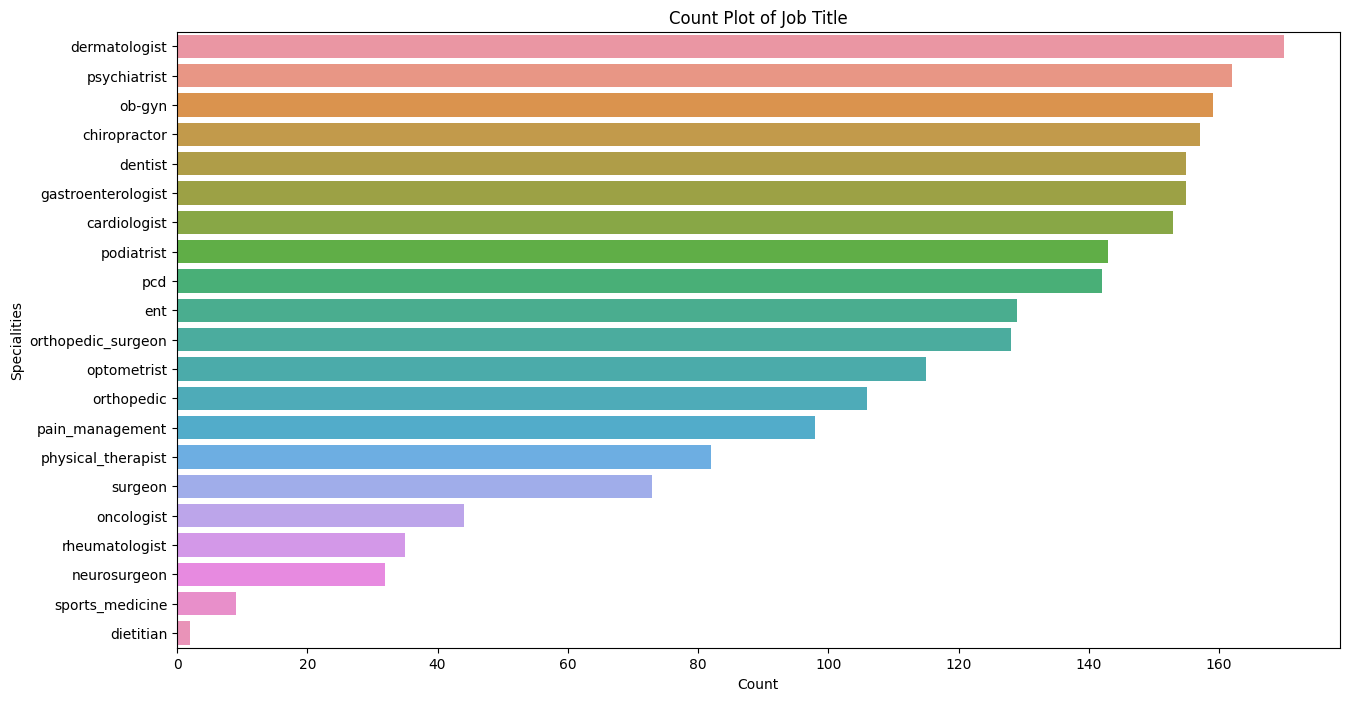

In [31]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))  # 2 rows, 2 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of columns to plot
columns = ['region', 'is_dr', 'is_nurse', 'is_assistant']

# Plot histograms
for i, column in enumerate(columns):
    sns.histplot(df_combined[column], ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Separate plot for 'job_title'
plt.figure(figsize=(15, 8))
sns.countplot(y=df_combined['job_title'], order=df_combined['job_title'].value_counts().index)
plt.title('Count Plot of Job Title')
plt.xlabel('Count')
plt.ylabel('Specialities')
plt.show()

In [32]:
# Save the DataFrame to a CSV file
df_combined.to_csv('df_combined.csv', index=False)